In [ ]:
import sys
sys.path.insert(0, "..")
%load_ext autoreload
%autoreload 2

In [199]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from src.features.modified_feature_selector import FeatureSelector
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
from collections import OrderedDict

sns.set()

uoa_colours = OrderedDict([
    ('Dark blue', '#00467F'),
    ('Light blue', '#009AC7'),
    ('Silver', '#8D9091')
    ])
uoa_faculty_colours = OrderedDict([
    ('Arts', '#A71930'),
    ('Business', '#7D0063'),
    ('Creative Arts and Industries', '#D2492A'),
    ('Education and Social Work', '#55A51C'),
    ('Engineering', '#4F2D7F'),
    ('Auckland Law School', '#005B82'),
    ('Medical and Health Sciences', '#00877C'),
    ('Science', '#0039A6')
])

def faculty_color_palette(faculty='Engineering'):
    faculties = list(uoa_faculty_colours.keys())
    assert faculty in faculties
    faculties.insert(0, faculties.pop(faculties.index(faculty)))
    colors = uoa_colours.copy()
    for faculty in faculties:
        colors[faculty] = uoa_faculty_colours[faculty]
    return sns.color_palette([color for name, color in colors.items()])

engineering_colors = faculty_color_palette()

sns.set_palette(engineering_colors)
sns.set_style('darkgrid')

In [2]:
# MULTICLASS CLASSIFICATION: Baseline vs. Ach vs. AT/Hex
df = pd.read_hdf('data/features/ach-at-hex_6000_eff_combined.h5')
y = pd.read_hdf('data/processed/y_4_class_6000.h5')
subject = pd.read_hdf('data/processed/subject_6000.h5')
mean = pd.read_hdf('data/features/6000/ach-at-hex_6000_mean_eff.h5')
mean = mean.reset_index(drop=True)
df = df.join(mean)
y = y.reset_index(drop=True)
subject = subject.reset_index(drop=True)


In [3]:
n_subjects = len(subject.unique())
features = []
targets = []
for s in subject.unique():
    features.append(df[subject==s])
    targets.append(y[subject==s])


In [21]:
for i in range(0,11):
    X = features[i]
    y = targets[i]
    print('loaded subject ', i)
    fs = FeatureSelector(ml_task='classification', multiclass=True, n_significant=2)
    print('selecting features...')
    fs.fit(X,y)
    X_filt = fs.transform(X)
    print('{:d} features selected'.format(len(fs.relevant_features)))
    rf = RandomForestClassifier()
    rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
    cv = cross_val_score(rf, X_filt, y, cv=rskf)

    selectors.append(fs)
    models.append(rf.fit(X_filt,y))
    results.append(cv)

    


loaded subject  0
selecting features...
8863 features selected
loaded subject  1
selecting features...
6883 features selected
loaded subject  2
selecting features...
5322 features selected
loaded subject  3
selecting features...
11305 features selected


In [31]:
mean_accuracies = [np.mean(i) for i in results]
mean_accuracies
order = [4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3]
subjects = [subject.unique()[i] for i in order]

In [94]:
top_features = []

In [95]:
for i in range(11):
    forest = models[i]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    top20=[]

    for f in range(30):
        print("%d. feature %s (%f)" % (f + 1, selectors[i].relevant_features[indices[f]], importances[indices[f]]))
        top20.append(selectors[i].relevant_features[indices[f]])

    top_features.append(top20)

    

isabs_True__qh_0.4__ql_0.0 (0.013476)
15. feature 22_21_diff__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4 (0.012303)
16. feature 24_21_diff__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2 (0.012055)
17. feature 57_56_diff__ar_coefficient__k_10__coeff_1 (0.011998)
18. feature 24__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"stderr" (0.011278)
19. feature 24__ar_coefficient__k_10__coeff_3 (0.010975)
20. feature 56__ar_coefficient__k_10__coeff_3 (0.010774)
21. feature 26_56_diff__ar_coefficient__k_10__coeff_1 (0.010462)
22. feature 56__ar_coefficient__k_10__coeff_4 (0.009955)
23. feature 52_56_diff__ar_coefficient__k_10__coeff_3 (0.009826)
24. feature 47_46_diff__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0 (0.009823)
25. feature 2_56_diff__ar_coefficient__k_10__coeff_4 (0.009576)
26. feature 2_56_diff__ar_coefficient__k_10__coeff_3 (0.009559)
27. feature 52_56_diff__ar_coefficient__k_10__coeff_2 (0.009404)
28. feature 47_46_diff__change_quantil

In [79]:
filtered = []
for i in range(11):
    fs = selectors[i]
    filtered.append(fs.transform(X))

5322

In [151]:
# refit using only top 30 features for each subject
refit_models = []
refit_results = []
for i in range(11):
    X = filtered[i]
    # X20 = X[top_features[i]]
    y = targets[i]
    print('loaded subject ', i)
    rf = RandomForestClassifier(n_estimators = 100, max_depth = 2)
    rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
    cv = cross_val_score(rf, X, y, cv=rskf)

    refit_models.append(rf.fit(X,y))
    refit_results.append(cv)

loaded subject  0
loaded subject  1
loaded subject  2
loaded subject  3
loaded subject  4
loaded subject  5
loaded subject  6
loaded subject  7
loaded subject  8
loaded subject  9
loaded subject  10


In [192]:
top_features = []
for i in range(11):
    forest = refit_models[i]
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    top10=[]

    for f in range(10):
        print("%d. feature %s (%f)" % (f + 1, selectors[i].relevant_features[indices[f]], importances[indices[f]]))
        top10.append(selectors[i].relevant_features[indices[f]])

    top_features.append(top10)

1. feature 13__linear_trend__attr_"stderr" (0.027820)
2. feature 3_56_diff__ar_coefficient__k_10__coeff_1 (0.026888)
3. feature 15__standard_deviation (0.021536)
4. feature 15__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr" (0.021307)
5. feature 14_13_diff__spkt_welch_density__coeff_8 (0.019440)
6. feature 14_13_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0 (0.019208)
7. feature 14__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr" (0.018581)
8. feature 14_13_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2 (0.017074)
9. feature 15__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr" (0.015815)
10. feature 10_13_diff__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2 (0.015754)
1. feature 55__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4 (0.014228)
2. feature 55_59_diff__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 (0.013788)
3. feature 38__quantile__q_0.9 (0.013149)
4. feature 55_59_dif

In [155]:
scores = pd.DataFrame([np.mean(i) for i in refit_results])
scores.columns = ['Accuracy']
scores['subject'] = scores.index + 1

In [156]:
scores

,Accuracy,subject
0,0.973617,1
1,0.971245,2
2,0.959980,3
3,0.993379,4
4,0.850692,5
5,0.986561,6
6,0.920059,7
7,0.982510,8
8,0.973123,9
9,0.982312,10


In [154]:
order = [7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6]
subject.unique()
refit_results = [refit_results[i] for i in order]

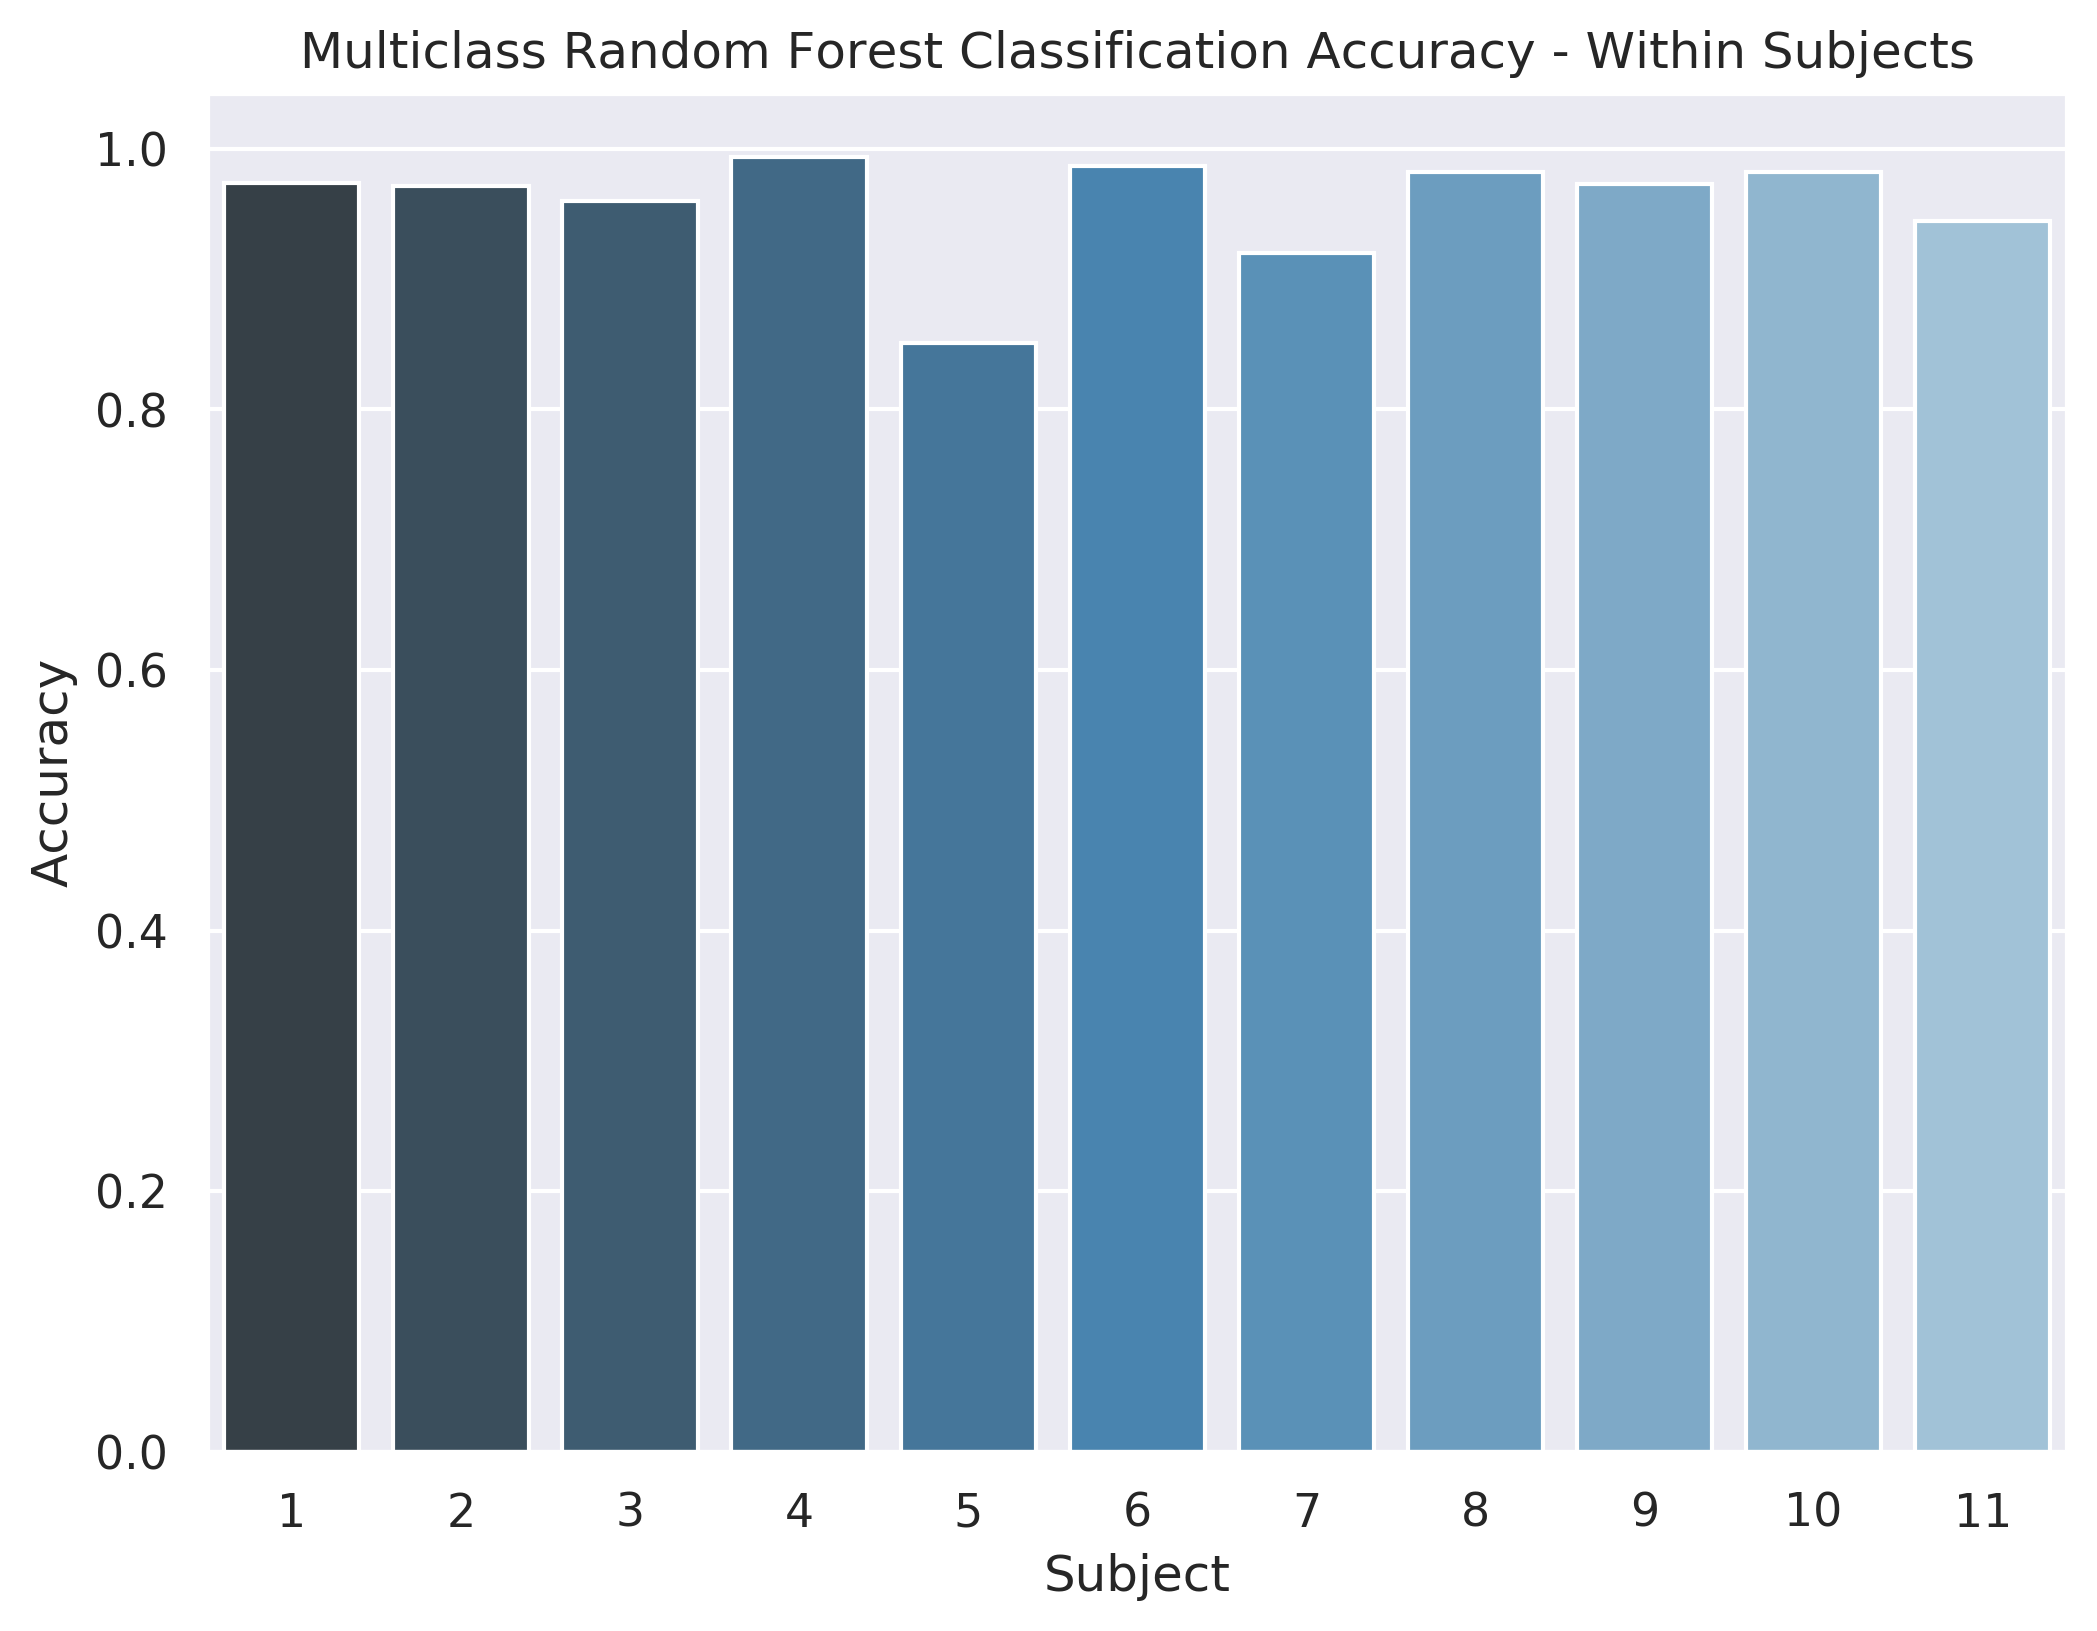

In [201]:
plt.figure(figsize=(8,6), dpi=300)
sns.set_style('darkgrid')
g = sns.barplot(x='subject', y='Accuracy', data=scores, palette='Blues_d')
g.set_title('Multiclass Random Forest Classification Accuracy - Within Subjects')
g.set_xlabel('Subject')
plt.savefig('reports/figures/in-subject-accuracy-multiclass')

In [99]:
top_features
flatten = lambda l: [item for sublist in l for item in sublist]
all_features = flatten(top_features)
all_features = pd.Series(all_features)

In [118]:
agg_linear_trend = all_features.str.count("agg_linear_trend").sum()
linear_trend = all_features.str.count("linear_trend").sum()
change_quantiles = all_features.str.count("change_quantiles__f_agg").sum()
variance = all_features.str.count("variance").sum()

In [127]:
subject.unique()

array(['00_0315_ach-at', '01_0126_ach-hex', '02_0126_ach-hex',
       '02_0315_ach-at', '03_0126_ach-hex', '04_0316_ach-at',
       '05_0201_ach-hex', '05_0316_ach-at', '06_0201_ach-hex',
       '06_0317_ach-at', '08_0201_ach-hex'], dtype=object)